## SOI Strip Waveguide (or Channel Waveguide)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

mp.verbosity(0);  # 0: minimal output; 1: a little; 2: a lot; 3: debugging

In [3]:
wavelength = 1.31  # Wavelength in µm
n_Si = 3.50685  # 3.50685 (1.31 µm) | 3.47638 (1.55 µm) 
n_SiO2 = 1.44672  # 1.44672 (1.31 µm) | 1.44400 (1.55 µm)
h_Si = 0.22  # Thickness in µm
w_Si = 0.41  # Width in µm (AMF 0.41 µm, VIS 0.40 µm)
d_pml = 0.5  # PML thickness in µm
resolution = 10  # pixels/µm

In [4]:
## Geometry
geometry = [mp.Block(size = mp.Vector3(mp.inf, w_Si, h_Si),
                     center = mp.Vector3(),
                     material = mp.Medium(index=n_Si))]

## Simulation domain
lx = 2*wavelength/n_SiO2
ly = 5*w_Si
lz = 5*h_Si
sx = lx + 2*d_pml
sy = ly + 2*d_pml
sz = lz + 2*d_pml

## Source
fcen = 1/wavelength
sources = [mp.EigenModeSource(mp.GaussianSource(frequency=fcen, fwidth=0.1*fcen),
                              center = mp.Vector3(-lx/2, 0, 0),
                              size = mp.Vector3(0, ly, lz),
                              eig_match_freq = True,  # Default True, try to find a mode with the same frequency as the src property
                              eig_band = 1,  # integer or DiffractedPlaneWave class, default 1, index of the desired band where 1 denotes the lowest-frequency band at a given k point
                              eig_parity = mp.ODD_Y+mp.EVEN_Z)]  # mp.ODD_Y+mp.EVEN_Z for TE mode (Hz,Ey); mp.EVEN_Y+mp.ODD_Z for TM mode (Ez,Hy)
## Simulation object
sim = mp.Simulation(geometry = geometry,
                    cell_size = mp.Vector3(sx, sy, sz),
                    boundary_layers = [mp.PML(d_pml)],
                    sources = sources,
                    resolution = resolution,
                    default_material = mp.Medium(index=n_SiO2))

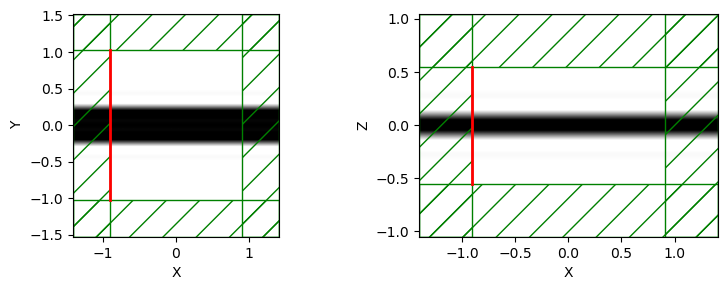

In [ ]:
plane_view = mp.simulation.Volume(center=mp.Vector3(), size=mp.Vector3(sx,sy,0)) # x-y 上視圖
side_view = mp.simulation.Volume(center=mp.Vector3(), size=mp.Vector3(sx,0,sz))  # x-z 側面圖

fig, axs = plt.subplots(1,2,figsize=(8,3))
sim.plot2D(output_plane=plane_view, ax=axs[0])
sim.plot2D(output_plane=side_view, ax=axs[1])
fig.tight_layout()

FloatProgress(value=0.0, description='0% done ', max=5.0)

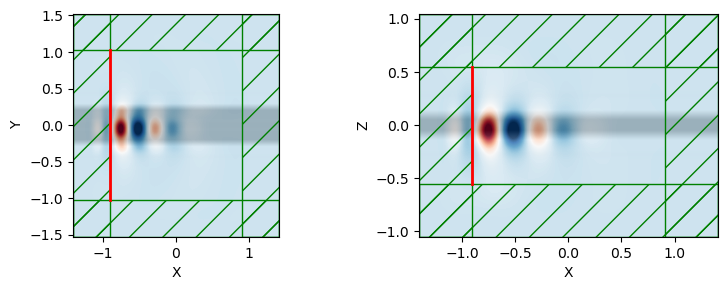

In [6]:
sim.reset_meep()
sim.run(until=5)
## stop_when_fields_decayed(dt, component, location, decay_by)
## keep incrementing runtime by dt
# sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, mp.Vector3(lx/2,0,0), 1e-6))

fig, axs = plt.subplots(1,2,figsize=(8,3))
sim.plot2D(output_plane=plane_view, fields=mp.Ey, ax=axs[0])
sim.plot2D(output_plane=side_view, fields=mp.Ey, ax=axs[1])
fig.tight_layout()

## FDTD solve with DFT (Discrete Fourier Transform) monitor

有限差分時域法 FDTD (Finite-Difference Time Domain)：求解電磁場在各個位置、各個時刻的數值

經過時域 Fourier Transform，可以得到頻域的 Response

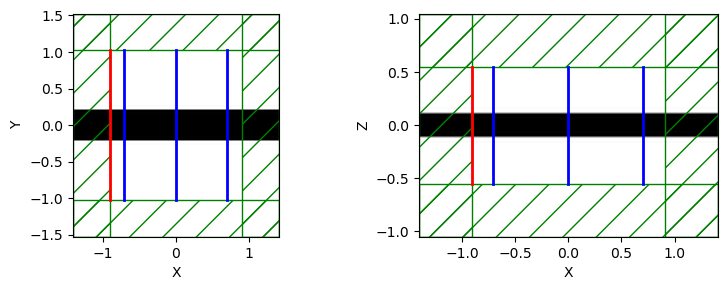

In [54]:
resolution = 40  # pixels/µm
sim = mp.Simulation(geometry = geometry,
                    cell_size = mp.Vector3(sx, sy, sz),
                    boundary_layers = [mp.PML(d_pml)],
                    sources = sources,
                    resolution = resolution,
                    default_material = mp.Medium(index=n_SiO2))
## DFT Field Monitor 會將截面的電磁場做時間的 Fourier transform 得到時間穩定下的電磁場頻域反應
dft_fields = sim.add_dft_fields([mp.Ey, mp.Ez],
                                fcen, 0, 1,
                                center = mp.Vector3(),
                                size = mp.Vector3(0,ly,lz),
                                yee_grid = True)
## add_flux(fcen, df, nfreq, freq, FluxRegions, decimation_factor=0) 用來計算穿過截面的電磁場能量
base_flux = sim.add_flux(fcen, 0, 1, 
                         mp.FluxRegion(center=mp.Vector3(-lx/2+0.2, 0, 0), 
                                       size=mp.Vector3(0, ly, lz)))
trans_flux = sim.add_flux(fcen, 0, 1, 
                          mp.FluxRegion(center=mp.Vector3(lx/2-0.2, 0, 0), 
                                        size=mp.Vector3(0, ly, lz)))

fig, axs = plt.subplots(1,2,figsize=(8,3))
sim.plot2D(output_plane=plane_view, ax=axs[0])
sim.plot2D(output_plane=side_view, ax=axs[1])
fig.tight_layout()

In [55]:
# sim.run(until=5)
## stop_when_fields_decayed(dt, component, location, decay_by)
## keep incrementing runtime by dt
sim.run(until_after_sources=mp.stop_when_fields_decayed(10, mp.Ey, mp.Vector3(0,0,0), 1e-6))

In [56]:
base_flux_ = mp.get_fluxes(base_flux)[0]
trans_flux_ = mp.get_fluxes(trans_flux)[0]

print("Base flux: %.4g" % base_flux_)
print("Transmitted flux: %.4g" % trans_flux_)
print("Transmission efficiency: %.4g %%" % (trans_flux_/base_flux_*100))

Base flux: 172.6
Transmitted flux: 172.6
Transmission efficiency: 99.99 %


(84, 46)
2.05 1.1


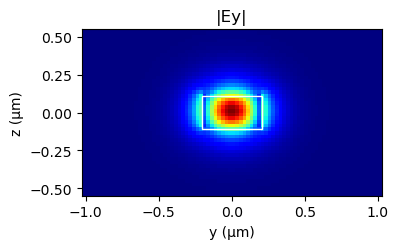

In [57]:
Ey = sim.get_dft_array(dft_fields, mp.Ey, 0)
print(Ey.shape)
print(ly, lz)

yy, zz = np.meshgrid(np.linspace(-ly/2, ly/2, Ey.shape[0]),
                     np.linspace(-lz/2, lz/2, Ey.shape[1]))

fig, ax = plt.subplots(figsize=(4,2.6))
ax.pcolormesh(yy, zz, np.transpose(np.abs(Ey)), cmap="jet")
ax.add_patch(plt.Rectangle((-w_Si/2, -h_Si/2), w_Si, h_Si, lw=1, ec='w', fc='none'))
ax.set(xlabel="y (µm)", ylabel="z (µm)", title="|Ey|",
       xlim=[-ly/2, ly/2], ylim=[-lz/2, lz/2])
fig.tight_layout()